In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from g2s.models.geometry_2_sphere import Mesh2Radar
from g2s.datasets.radar_dataset import RadarDataset
from g2s.datasets.transforms.general import Compose
from g2s.datasets.transforms.radar import Log, Abs, Normalize, Center
from g2s.datasets.transforms.mesh import MeshNormalize

import numpy as np
import matplotlib.pyplot as plt
from eharmony import plotting
from torch_geometric.loader import DataLoader
import xarray
import torch
from torch import nn
from pathlib import Path
from hydra_zen import load_from_yaml, instantiate, get_target

## Load config file

In [26]:
cfg = load_from_yaml("../config/g2s_frusta.yaml") #Change path to the config file if necessary

## Load model checkpoint

In [20]:

cfg = load_from_yaml("../config/g2s_frusta.yaml") #Change path to the config file if necessary
g2s = get_target(cfg.module)
g2s = g2s.load_from_checkpoint(
    '/home/gridsan/ppatel1/DE-RM/results_ffm/hydra/frusta_full_range_lmax_70_mlp/2024-09-24/01-46-42/model_epoch=48.ckpt', #Change path to model checkpoint
    backbone=instantiate(cfg.module.backbone),
    criterion=instantiate(cfg.module.criterion),
    optim=instantiate(cfg.module.optim),
)


Lightning automatically upgraded your loaded checkpoint from v1.9.5 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../results_ffm/hydra/frusta_full_range_lmax_70_mlp/2024-09-24/01-46-42/model_epoch=48.ckpt`


## Load dataset

In [27]:

test_ds_fp = '../../data/frusta/test_dataset_small.nc' # change dataset path if necessary
ds = RadarDataset(
    test_ds_fp,
    'test',
    seed=0,
    transform=instantiate(cfg.test_dataset.transform),
    shuffle_before_split=False,
    mesh_mode='simple',
    orientation_mode='full',
)


In [37]:
dl = DataLoader(ds, batch_size=1, num_workers=0, shuffle=True)
itr = iter(dl)

In [30]:
if torch.cuda.is_available():
    g2s = g2s.cuda()

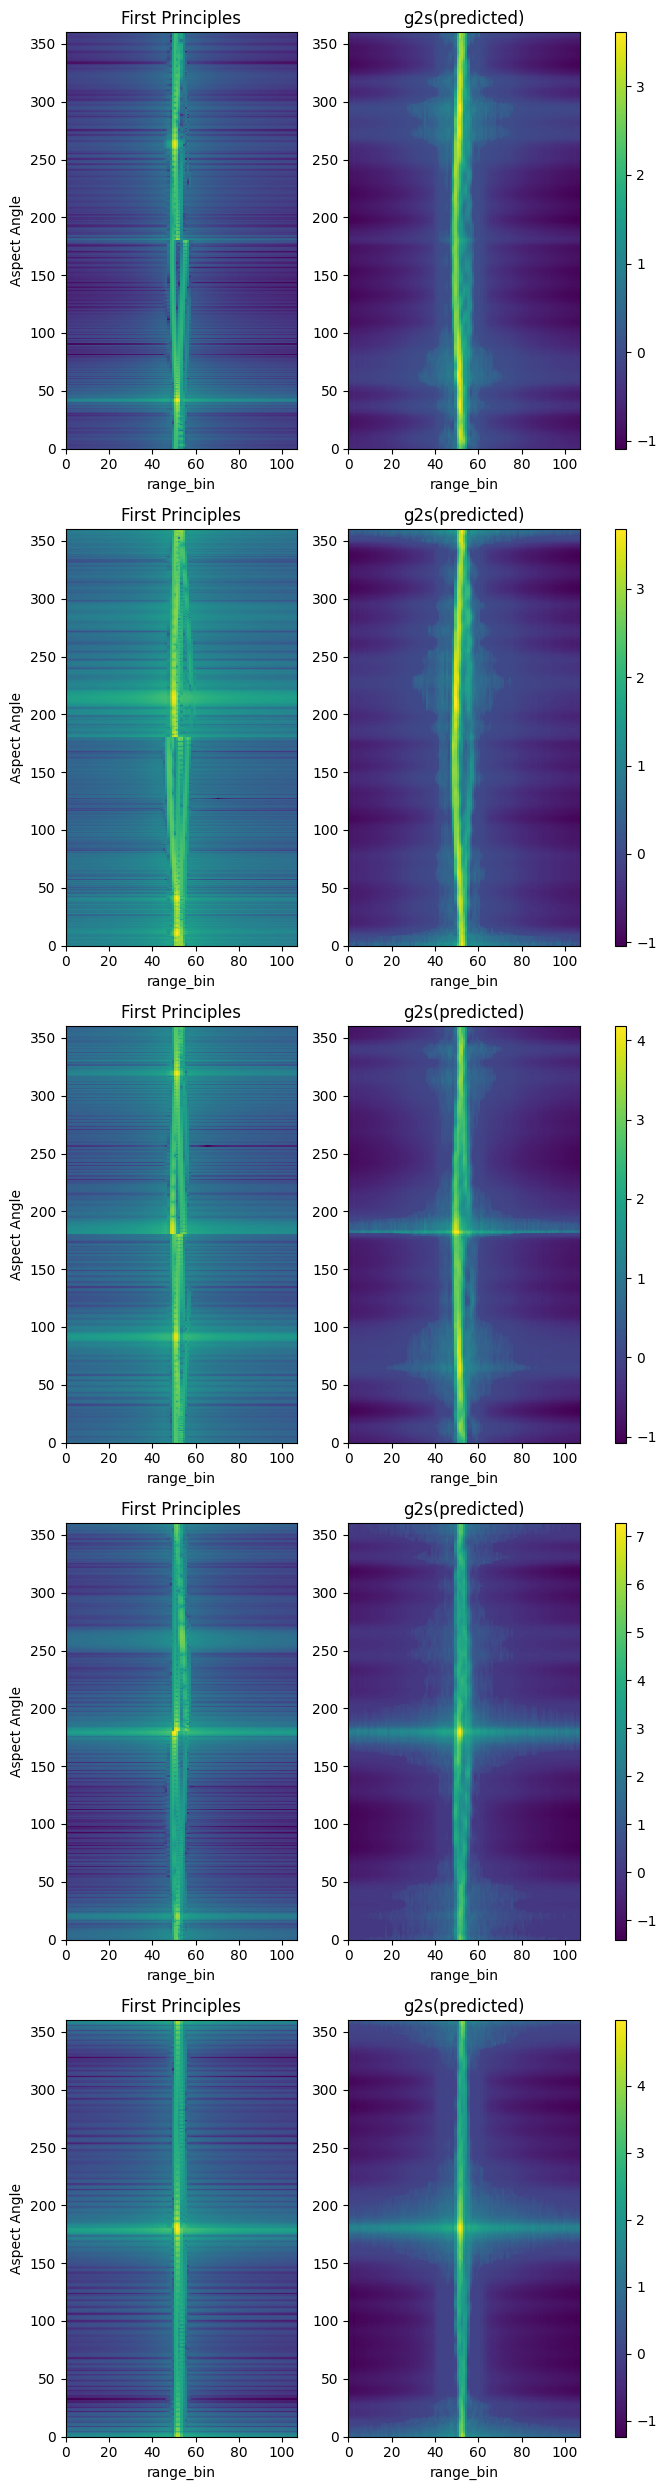

In [47]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(6,25))

for j in range(5):
    mesh, response = next(itr)
    if torch.cuda.is_available():
        mesh = mesh.cuda()
    
    with torch.no_grad():
        predicted_response, w = g2s(mesh)
 
    im = ax[j][1].pcolormesh(predicted_response[0,:,:,0].cpu().numpy().T)
    ax[j][0].pcolormesh(response[0,:,:,0].T)
    
    ax[j][0].set_xlabel('range_bin')
    ax[j][0].set_xticks([0,20,40,60,80,100])
    ax[j][1].set_xlabel('range_bin')
    ax[j][1].set_xticks([0,20,40,60,80,100])
    ax[j][0].set_ylabel('Aspect Angle')
    ax[j][0].set_title('First Principles')
    ax[j][1].set_title('g2s(predicted)')
    
    axins = inset_axes(
        ax[j,1],
        width="5%",  # width: 50% of parent_bbox width
        height="100%",  # height: 5%
        loc="right",
        bbox_to_anchor=(0.2, 0., 1, 1),
        bbox_transform=ax[j,1].transAxes,
        borderpad=0,
    )
    fig.colorbar(im, cax=axins)
        
plt.tight_layout()
plt.show()